### Imports

In [1]:
import numpy as np
import pickle
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.base import clone

### Load Data

In [2]:
with open('keypoints2', 'rb') as file:
    data = pickle.load(file)

#### Process By Gloss

In [3]:
X = []
y = []
gloss_map = []
for index, (name, gloss) in enumerate(data.items()):
    gloss_map.append(name)
    xs = []
    for frame in [frame 
        for variant in gloss.values() 
        for session in variant.values() 
        for frame in session]:
        xs.append(frame['hand_left_keypoints_2d'] + frame['hand_right_keypoints_2d'])
    ys = np.full((len(xs)), index)
    X.append(xs)
    y.append(ys)
X = np.concatenate(X, axis=0)
y = np.concatenate(y)

### Split Test Train

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)

### Learning Curve

In [5]:
def learning_curve(model, X_train, X_test, y_train, y_test):
    train_scores = []
    test_scores = []
    
    for i in np.arange(0.1, 1.1, 0.1):
        train_size = int(len(X_train) * i)
        X_train_ = X_train[:train_size]
        y_train_ = y_train[:train_size]
        
        model_ = clone(model)
        model_.fit(X_train_, y_train_)
        train_pred = model_.predict(X_train_)
        test_pred = model_.predict(X_test)
        
        train_acc = accuracy_score(y_train_, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        train_scores.append(train_acc)
        test_scores.append(test_acc)
        
        print(f'{int(i * 100)}%', end=' ')
    print()
        
    plt.plot(train_scores, label='Train')
    plt.plot(test_scores, label='Test')
    plt.title('Learning Curve')
    plt.ylabel('Accuracy')
    plt.xlabel('% of Training Size')
    plt.xticks(range(10), (np.arange(0.1, 1.1, 0.1) * 100).astype(int))
    plt.ylim(0.0, 1.01)
    plt.legend()
    
    print(f'Final Training Accuracy: {train_scores[-1] * 100}%')
    print(f'Final Testing Accuracy: {test_scores[-1] * 100}%')

### Models

#### Random Forest Classifier

10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
Final Training Accuracy: 99.97950819672131%
Final Testing Accuracy: 98.51816443594646%


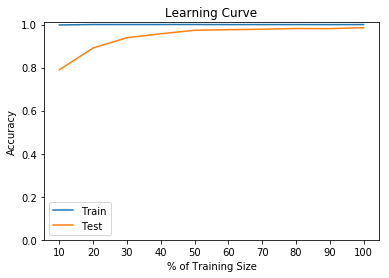

In [9]:
forest = RandomForestClassifier(n_estimators=10, n_jobs=-1)
learning_curve(forest, X_train, X_test, y_train, y_test)

#### Support Vector Classifier

In [7]:
svc = SVC(gamma='auto')
#learning_curve(svc, X_train, X_test, y_train, y_test)

In [8]:
clf = GridSearchCV(svc, {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}, verbose=10, n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.best_estimator_)

c:\users\cat\miniconda3\envs\a\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.0min remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [12]:
clf.cv_results_

{'mean_fit_time': array([10.91612768,  1.72043824, 11.39594142,  2.02515109, 11.53623009,
         1.92259812, 11.78829328,  1.87133129, 11.75552956,  1.94310625]),
 'std_fit_time': array([0.10017437, 0.03197671, 0.22618872, 0.1015901 , 0.33074536,
        0.09403552, 0.36966733, 0.22611317, 0.19334435, 0.04307447]),
 'mean_score_time': array([3.22698061, 1.36942434, 3.36604865, 1.42983834, 3.15109936,
        1.37293061, 3.191667  , 1.38446403, 2.86229722, 1.37389604]),
 'std_score_time': array([0.03375862, 0.03132886, 0.14795156, 0.05381809, 0.14958665,
        0.05055349, 0.02485636, 0.0272841 , 0.10884088, 0.05426774]),
 'param_C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10, 100, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear',
                    'rbf', 'linear', 'rb

In [13]:
clf_pred = clf.predict(X_test)
clf_acc = accuracy_score(y_test, clf_pred)
print('Accuracy:', clf_acc)

Accuracy: 0.984225621414914


In [15]:
clf.best_params_

{'C': 0.01, 'kernel': 'linear'}

In [10]:
with open('randomforest', 'wb') as file:
    data = pickle.dump(forest, file)
    
with open('svc', 'wb') as file:
    data = pickle.dump(svc, file)